# Example of hyperfine quadrupole spectrum of $\text{S}_2^{35}\text{Cl}^{37}\text{Cl}$ molecule

In this example, we simulate the rotational hyperfine spectrum of $\text{S}_2^{35}\text{Cl}^{37}\text{Cl}$, including the forbidden ortho-para transitions, observed by [Mizoguchi], and compare with results of theoretical simulations.

The hyperfine interaction is represented by the nuclear quadrupole coupling of the two chlorine nuclei.
Each chlorine nucleus has a nuclear spin of $I = \tfrac{3}{2}$ and a nuclear quadrupole moment of $Q(^{35}\text{Cl}) = -81.65$ mb and $Q(^{37}\text{Cl}) = -64.35$ mb  [Pyykkö].

The molecular geometry, dipole moment, and electric field gradient tensors (EFG) used in this simulation are defined in the module [s2cl2_dft.py](s2cl2_dft.py) or [s2cl2_cc.py](s2cl2_cc.py).

We employ effective-Hamiltonian constants for the pure rotational solutions, as given in Table 4 of [Mizoguchi].

References:
- [Mizoguchi] Mizoguchi, Otaa, Kanamori, Sumiyoshi, Endo, J. Mol. Spectrosc. 250 (2008) 86, DOI: http://dx.doi.org/10.1016/j.jms.2008.04.012
- [Pyykkö] Pyykkö, Year-2008 Nuclear Quadrupole Moments, Mol. Phys. 106 (2008) 1965, DOI: http://dx.doi.org/10.1080/00268970802018367

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import s2cl2_cc as s2cl2
from matplotlib.ticker import FuncFormatter, MaxNLocator
from plot_dens import plot_mc_dens, plot_mc_spin_dens
from scipy import constants
from scipy.sparse import csr_array

from richmol import (
    CartTensor,
    HyperCartTensor,
    HyperStates,
    QuadMom,
    RotStates,
    Spin1Tensor,
)
from richmol.asymtop import com, inertia_tensor, rotational_constants, write_xyz

plt.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern"]}
)

Rotate *ab initio* calculated geometry, dipole moment, and EFG tensors to the principal axes system (PAS).

In [2]:
atom_masses = s2cl2.atom_masses_35_37
atom_labels = s2cl2.atom_labels_35_37

(A, B, C), v = rotational_constants(atom_masses, s2cl2.atom_xyz)
kappa = (2 * B - A - C) / (A - C)
print("A, B, C (cm^-1):", A, B, C)
print("A, B, C (MHz):", *(elem * constants.c * 1e-4 for elem in (A, B, C)))
print("kappa:", kappa)
if kappa < 0:
    print("prolate top")
    perm_mat = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]])
else:
    print("oblate top")
    perm_mat = np.eye(3)

pas = perm_mat @ v.T

atom_xyz = (s2cl2.atom_xyz - com(atom_masses, s2cl2.atom_xyz)) @ pas.T
write_xyz("s2cl2_35_37_pas_coords.xyz", atom_labels, atom_xyz)

# check that inertia tensor is diagonal in PAS
imom = inertia_tensor(atom_masses, atom_xyz)
print(
    "Inertia tensor diagonal?:",
    np.allclose(imom, np.diag(np.diagonal(imom)), atol=1e-12),
)

dip_mol = pas @ np.array(s2cl2.dip_mol)
efg_mol_cl1 = pas @ np.array(s2cl2.efg_mol_cl1) @ pas.T
efg_mol_cl2 = pas @ np.array(s2cl2.efg_mol_cl2) @ pas.T

print("Dipole moment in PAS:\n", dip_mol)
print("EFG on Cl1 in PAS:\n", efg_mol_cl1)
print("EFG on Cl2 in PAS:\n", efg_mol_cl2)

print("EFG(Cl1) - EFG(Cl2) (diag):\n", np.diag(efg_mol_cl1 - efg_mol_cl2))

A, B, C (cm^-1): 0.17568178346192662 0.044738213315865964 0.03956877371251808
A, B, C (MHz): 5266.807368987474 1341.217893649179 1186.241993132158
kappa: -0.9240419470135132
prolate top
Inertia tensor diagonal?: True
Dipole moment in PAS:
 [0.36511725 0.00200879 0.00372382]
EFG on Cl1 in PAS:
 [[ 0.84895274  1.55998363 -2.44222562]
 [ 1.55998363 -1.15047094 -1.12099952]
 [-2.44222562 -1.12099952  0.3015182 ]]
EFG on Cl2 in PAS:
 [[ 0.78270406 -1.51524797  2.46405952]
 [-1.51524797 -1.1843074  -1.12536676]
 [ 2.46405952 -1.12536676  0.40160333]]
EFG(Cl1) - EFG(Cl2) (diag):
 [ 0.06624867  0.03383646 -0.10008513]


In [3]:
print(" & ".join("%7.3f"% elem for elem in efg_mol_cl1[np.triu_indices(3)]))
print(" & ".join("%7.3f"% elem for elem in efg_mol_cl2[np.triu_indices(3)]))

  0.849 &   1.560 &  -2.442 &  -1.150 &  -1.121 &   0.302
  0.783 &  -1.515 &   2.464 &  -1.184 &  -1.125 &   0.402


In [4]:
# Rotational constants from [Mizoguchi]
inp = (
    "A/MHz",      5475.4344,
    "B/MHz",      1361.8640,
    "C/MHz",      1205.1953,
    "DeltaJ/kHz",    0.554,
    "DeltaJK/kHz",  -4.465,
    "DeltaK/kHz",   22.68,
    "d1/kHz",        0.054,
)

jmax = 20
states = RotStates.watson(
    jmax,
    inp,
    print_enr=True,
)

dip_lab = CartTensor(states, dip_mol)
efg_lab_cl1 = CartTensor(states, efg_mol_cl1)
efg_lab_cl2 = CartTensor(states, efg_mol_cl2)


Compute rotational solutions using Watson's effective Hamiltonian approach
Input rotational constants (MHz):
          A  5475.434400000000 
          B  1361.864000000000 
          C  1205.195300000000 
     DeltaJ     0.000554000000 
    DeltaJK    -0.004465000000 
     DeltaK     0.022680000000 
         d1     0.000054000000 
Watson reduction form: S
Axes convention for near-prolate: I(r), xyz = bca
Remark: manually apply permutation (132) to other input Cartesian tensors (like dipole moment) in the PAS frame,
   e.g., using permutation matrix np.array([[0,1,0],[0,0,1],[1,0,0]])
solve for J = 0 and symmetry A ...
number of functions: 1
Axes convention for near-prolate: I(r), xyz = bca
Remark: manually apply permutation (132) to other input Cartesian tensors (like dipole moment) in the PAS frame,
   e.g., using permutation matrix np.array([[0,1,0],[0,0,1],[1,0,0]])
solve for J = 1 and symmetry A ...
number of functions: 3
Axes convention for near-prolate: I(r), xyz = bca
Remark: m

Compute hyperfine states using effective-Hamiltonian rotational states, ab initio calculated EFG tensors, and quadrupole moments from [Pyykkö].

In [5]:
# Compute rotational matrix elements of laboratory-frame tensors

# Quadrupole moments of {35}^Cl and {37}^Cl (in mb) from [Pyykkö]
quad_cl35 = QuadMom(spin=3 / 2, Q=-81.65)
quad_cl37 = QuadMom(spin=3 / 2, Q=-64.35)

# Compute hyperfine states and matrix elements of laboratory-frame tensors

hyper_states = HyperStates(
    0,
    jmax - 3,
    states,
    spin_op=[quad_cl35, quad_cl37],
    efg_op=[efg_lab_cl1, efg_lab_cl2],
)

# convert matrix elements of lab-frame dipole moment to hyperfine basis
hyper_dip_lab = HyperCartTensor(hyper_states, dip_lab)


Compute hyperfine states
List of F quanta: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0)]
F   tot.sym.   J   (I_1, I_12, ... I_1N)     rovib.sym.   spin.sym.  rovib.dim 
----------------------------------------------------------------------------
0.0 A          0   (1.5, 0)                  A            A          1         
0.0 A          1   (1.5, 1)                  A            A          3         
0.0 A          2   (1.5, 2)                  A            A          5         
0.0 A          3   (1.5, 3)                  A            A          7         
1.0 A          1   (1.5, 0)                  A            A          3         
1.0 A          0   (1.5, 1)                  A            A          1         
1.0 

Print the hyperfine states and assignments, as well as the weights of ortho and para contributions.

In [6]:
# zero-point energy
zpe = np.min(
    [
        np.min(enr_sym)
        for enr_f in hyper_states.enr.values()
        for enr_sym in enr_f.values()
    ]
)

enr = []
for f in hyper_states.enr.keys():
    for sym in hyper_states.enr[f].keys():

        # extract (J, k, tau, I, F) quanta
        quanta = hyper_states.quanta_dict_k[f][sym]
        j_k_tau_i_f = [
            (*elem[6:9], elem[3], float(elem[0]), sym)
            for elem in hyper_states.quanta_dict_k[f][sym]
        ]

        # p(I) = \sum_i |c_i|^2 for spin I=0,1,2,3
        op_quanta = hyper_states.quanta_dict_op[f][sym]

        # compute p(para) = \sum_i |c_i|^2 for spin in (0, 2)
        #     and p(ortho) = \sum_i |c_i|^2 for spin in (1, 3)
        para_coef = [sum(c for (q, c) in qua if int(q) in (0, 2)) for qua in op_quanta]
        ortho_coef = [sum(c for (q, c) in qua if int(q) in (1, 3)) for qua in op_quanta]

        # assemble (J, k, tau, I, F, energy-zpe, p(para), p(ortho))
        enr += [
            (*q, float(e - zpe), pc, oc, ind)
            for ind, (q, e, pc, oc) in enumerate(
                zip(j_k_tau_i_f, hyper_states.enr[f][sym], para_coef, ortho_coef)
            )
        ]


# sort wrt energy
enr = sorted(enr, key=lambda elem: elem[5])


print(
    f"{'J':>2} {'k':>2} {'tau':>1} {'I':>1} {'F':>2} {'Energy (MHz)':>16} {'p_para':>10} {'p_ortho':>10}"
)
for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    print(
        f"{j:2d}",
        f"{k:2d}",
        f"{tau:2d}",
        f"{int(spin):2d}",
        f"{int(f):2d}",
        f"{e:16.4f}",
        f"{p_c:10.6f}",
        f"{o_c:10.6f}",
    )

 J  k tau I  F     Energy (MHz)     p_para    p_ortho
 0  0  0  0  0           0.0354   1.000000   0.000000
 1  0  1  1  0        2564.6982   0.000002   0.999998
 1  1  1  1  0        6675.0117   0.000003   0.999997
 1  1  0  1  0        6844.9121   0.000499   0.999501
 2  0  0  2  0        7697.2160   0.999500   0.000500
 2  1  0  2  0       11658.1126   0.999997   0.000003
 2  1  1  2  0       12127.9965   0.999951   0.000049
 3  0  1  3  0       15383.5357   0.000045   0.999955
 3  1  1  3  0       19130.1866   0.000008   0.999992
 3  1  0  3  0       20056.5232   0.000012   0.999988
 2  2  1  2  0       24468.6034   0.999993   0.000007
 2  2  0  2  0       24473.0194   0.999989   0.000011
 3  2  0  3  0       32169.7990   0.000000   1.000000
 3  2  1  3  0       32191.1115   0.000000   1.000000
 3  3  1  3  0       53127.7976   0.000000   1.000000
 3  3  0  3  0       53127.8713   0.000000   1.000000
 0  0  0  1  1           0.0177   0.000002   0.999998
 1  0  1  2  1        2565.1

Plot *para* (*ortho*) weights for states as function of their energy.

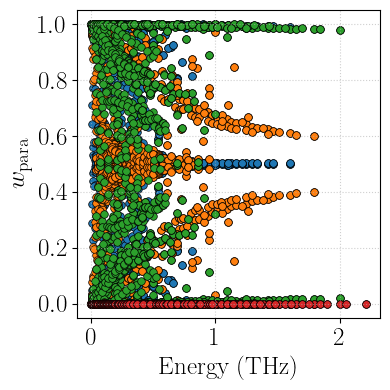

In [7]:
e_j = {}
for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    try:
        e_j[abs(f - j)].append((e, p_c))
    except KeyError:
        e_j[abs(f - j)] = [(e, p_c)]

fig = plt.figure(figsize=(4, 4), dpi=100)

colors = {0.0: "tab:blue", 1.0: "tab:orange", 2.0: "tab:green", 3.0: "tab:red"}

for key in sorted(list(e_j.keys())):
    e, p = np.array(e_j[key]).T
    plt.scatter(
        e/1e6 if hyper_states.enr_units == "mhz" else e,
        p,
        marker="o",
        label=f"{int(key)}",
        s=30,
        facecolors=colors[key],
        edgecolors="black",
        linewidth=0.5,
    )

plt.grid(True, linestyle=":", alpha=0.6)
plt.tick_params(axis="both", labelsize=18)
if hyper_states.enr_units == "mhz":
    plt.xlabel("Energy (THz)", fontsize=18)
else:
    plt.xlabel("Energy (cm$^{-1}$)", fontsize=18)
plt.ylabel("$w_{\\rm para}$", fontsize=18)
# plt.legend(fontsize=16, title_fontsize=16, loc="upper right", title="$|F-J|$")
plt.tight_layout()
plt.savefig(f"s2cl2_35_37_op_diagram.pdf", format="pdf", bbox_inches="tight")

Same plot as above, color-coded wrt $k$.

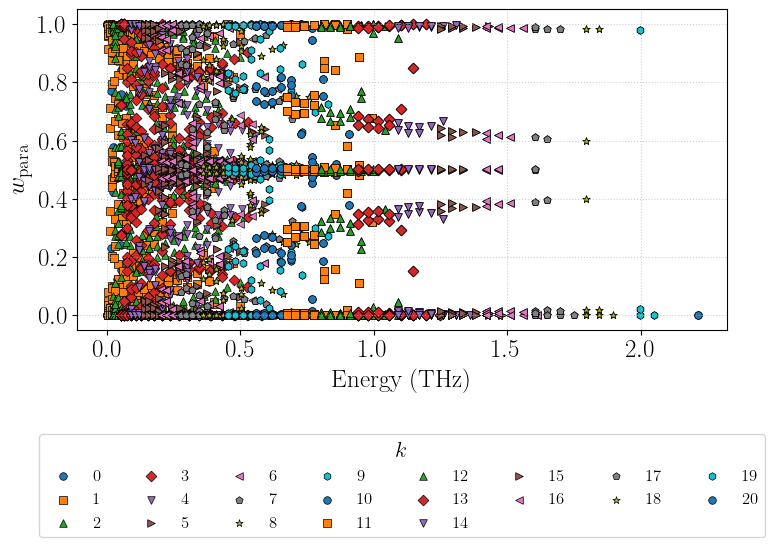

In [8]:
e_j = {}
for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    try:
        e_j[k].append((e, p_c))
    except KeyError:
        e_j[k] = [(e, p_c)]

fig = plt.figure(figsize=(8, 6), dpi=100)

markers = ["o", "s", "^", "D", "v", ">", "<", "p", "*", "h"]

for i, key in enumerate(sorted(list(e_j.keys()))):
    e, p = np.array(e_j[key]).T
    plt.scatter(
        e / 1e6 if hyper_states.enr_units == "mhz" else e,
        p,
        marker=markers[i % len(markers)],
        # label=f"{int(key)}",
        label=f"{key}",
        s=30,
        edgecolors="black",
        linewidth=0.5,
    )

plt.grid(True, linestyle=":", alpha=0.6)
plt.tick_params(axis="both", labelsize=18)
if hyper_states.enr_units == "mhz":
    plt.xlabel("Energy (THz)", fontsize=18)
else:
    plt.xlabel("Energy (cm$^{-1}$)", fontsize=18)
plt.ylabel("$w_{\\rm para}$", fontsize=18)
plt.legend(
    fontsize=12,
    title_fontsize=16,
    ncol=8,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    title="$k$",
)
plt.tight_layout()

Zoom into specific $k$, color-coded wrt $J$

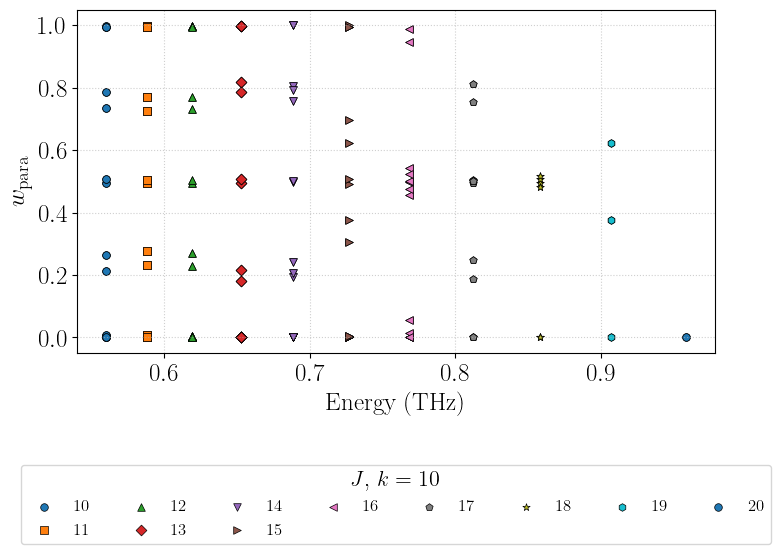

In [9]:
k0 = 10
e_j = {}
for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    if k != k0:
        continue
    try:
        e_j[j].append((e, p_c))
    except KeyError:
        e_j[j] = [(e, p_c)]

fig = plt.figure(figsize=(8, 6), dpi=100)

markers = ["o", "s", "^", "D", "v", ">", "<", "p", "*", "h"]

for i, key in enumerate(sorted(list(e_j.keys()))):
    e, p = np.array(e_j[key]).T
    plt.scatter(
        e / 1e6 if hyper_states.enr_units == "mhz" else e,
        p,
        marker=markers[i % len(markers)],
        label=f"{key}",
        s=30,
        edgecolors="black",
        linewidth=0.5,
    )

plt.grid(True, linestyle=":", alpha=0.6)
plt.tick_params(axis="both", labelsize=18)
if hyper_states.enr_units == "mhz":
    plt.xlabel("Energy (THz)", fontsize=18)
else:
    plt.xlabel("Energy (cm$^{-1}$)", fontsize=18)
plt.ylabel("$w_{\\rm para}$", fontsize=18)
plt.legend(
    fontsize=12,
    title_fontsize=16,
    ncol=8,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    title=f"$J$, $k={k0}$",
)
plt.tight_layout()

### Analyze states using expectation values of nuclear spin operators and spin-densities

Compute expectation values of nuclear spin operators for selected states (e.g., selected $k$-branch on the plot above) and compare the distributions for states with $w_\text{para}\approx 1$ and $w_\text{para}\approx 0.5$.

In [10]:
# Returns expectation value for a selected Cartesian component of nuclear spin
# operators for given m_F and index of hyperfine state
def spin_me(cart_comp: str, f: float, sym: str, m: float, ind: int):
    m_ind = np.where(np.arange(-f, f + 1) == m)[0][0]
    mmat1 = spin_tens1.mmat[(f, f)][cart_comp][1].toarray()[m_ind, m_ind]
    kmat1 = spin_tens1.kmat[(f, f)][(sym, sym)][1].toarray()[ind, ind]
    mmat2 = spin_tens2.mmat[(f, f)][cart_comp][1].toarray()[m_ind, m_ind]
    kmat2 = spin_tens2.kmat[(f, f)][(sym, sym)][1].toarray()[ind, ind]
    return kmat1 * mmat1, kmat2 * mmat2

spin_tens1 = Spin1Tensor(0, hyper_states)
spin_tens2 = Spin1Tensor(1, hyper_states)

print(
    f"{'j':>3} {'k':>3} {'tau':>4} {'I':>4} {'F':>4} {'ind':>6} {'E (MHz)':>14} {'|F - J|':>7} {'p_c':>6} {'o_c':>6} {'sym':>6}"
)
cart_comp = "z"

for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    m = f
    if k == 10 and j in (10,):  # select k and J

        spin_me1, spin_me2 = spin_me(cart_comp, f, sym, m, ind)
        eTHz = round(e / 1e6, 6)
        eMHz = round(e, 4)

        if abs(p_c - 0.5) < 0.2:
            op = "mixed"
        elif p_c - 0.5 > 0.2:
            op = "para"
        else:
            op = "ortho"

        # print(
        #     f"{j:3} {k:3} {tau:4} {spin:4} {f:4} {ind:6} {eMHz:14.4f} {abs(j - f):7.1f} {p_c:6.1f} {o_c:6.1f} {op:>6} {spin_me1} {spin_me2}"
        # )

        print(
            f"{j:3} & {k:3} & {tau:4} & {round(spin):4} & {round(f):4} & {eMHz:14.4f} & {p_c:6.2f} & {o_c:6.2f} & {spin_me1.real:10.3f} & {spin_me2.real:10.3f} \\\\"
        )

  j   k  tau    I    F    ind        E (MHz) |F - J|    p_c    o_c    sym
 10 &  10 &    1 &    3 &    7 &    560199.1545 &   0.00 &   1.00 &     -1.312 &     -1.312 \\
 10 &  10 &    0 &    3 &    7 &    560199.1545 &   0.00 &   1.00 &     -1.312 &     -1.312 \\
 10 &  10 &    1 &    3 &    8 &    560201.3164 &   0.01 &   0.99 &     -0.647 &     -0.799 \\
 10 &  10 &    0 &    3 &    8 &    560201.3164 &   0.01 &   0.99 &     -0.647 &     -0.799 \\
 10 &  10 &    0 &    2 &    8 &    560202.1378 &   0.99 &   0.01 &     -0.964 &     -0.812 \\
 10 &  10 &    1 &    2 &    8 &    560202.1378 &   0.99 &   0.01 &     -0.964 &     -0.812 \\
 10 &  10 &    0 &    3 &    9 &    560202.0034 &   0.21 &   0.79 &      0.484 &     -1.120 \\
 10 &  10 &    1 &    3 &    9 &    560202.0034 &   0.21 &   0.79 &      0.484 &     -1.120 \\
 10 &  10 &    0 &    2 &    9 &    560202.1712 &   0.79 &   0.21 &     -1.142 &      0.460 \\
 10 &  10 &    1 &    2 &    9 &    560202.1712 &   0.79 &   0.21 &    

Plot rotational spin-densities for selected states (e.g., selected $k$-branch on the plot above) and compare the distributions for states with $w_\text{para}\approx 1$ and $w_\text{para}\approx 0.5$.

In [11]:
print(
    f"{'j':>3} {'k':>3} {'tau':>4} {'spin':>4} {'F':>4} {'ind':>6} {'E (THz)':>10} {'|F - J|':>7} {'p_c':>6} {'o_c':>6} {'sym':>6}"
)
cart_comp = "z"

for j, k, tau, spin, f, e, p_c, o_c, ind in enr:
    m = f
    if k == 10 and j in (10,):  # select k and J
        eTHz = round(e / 1e6, 6)

        if abs(p_c - 0.5) < 0.2:
            op = "mixed"
        elif p_c - 0.5 > 0.2:
            op = "para"
        else:
            op = "ortho"

        print(
            f"{j:3} {k:3} {tau:4} {spin:4} {f:4} {ind:6} {eTHz:10.6f} {abs(j - f):7.1f} {p_c:6.1f} {o_c:6.1f} {op:>6}"
        )

        # plot_mc_dens(
        #     hyper_states,
        #     states,
        #     f,
        #     "A",
        #     m,
        #     ind,
        #     atom_xyz[2:],  # Cl1 and Cl2
        #     atom_labels=atom_labels[2:],  # Cl1 and Cl2
        #     npoints=200000,
        #     filename=f"dens_plots/s2cl2_35_37_dens_wp{round(p_c,2)}_f{f}_j{j}_k{k}_tau{tau}_m{m}_ind{ind}.png",
        #     coef_thresh=1e-4,
        # )

        plot_mc_spin_dens(
            hyper_states,
            states,
            f,
            "A",
            m,
            ind,
            atom_xyz[2:],  # Cl1 and Cl2
            atom_labels=atom_labels[2:],  # Cl1 and Cl2
            cart_comp=cart_comp,
            npoints=200000,
            filename=f"dens_plots/s2cl2_35_37_spindens_{cart_comp}_wp{round(p_c,2)}_f{f}_j{j}_k{k}_tau{tau}_m{m}_ind{ind}.png",
            coef_thresh=1e-4,
        )

  j   k  tau spin    F    ind    E (THz) |F - J|    p_c    o_c    sym
 10  10    1  3.0  7.0    238   0.560199     3.0    0.0    1.0  ortho
 10  10    0  3.0  7.0    239   0.560199     3.0    0.0    1.0  ortho
 10  10    1  1.0 10.0    294   0.560200     0.0    0.5    0.5  mixed
 10  10    0  1.0 10.0    295   0.560200     0.0    0.5    0.5  mixed
 10  10    0  1.0 10.0    296   0.560200     0.0    0.5    0.5  mixed
 10  10    1  1.0 10.0    297   0.560200     0.0    0.5    0.5  mixed
 10  10    1  3.0 13.0    278   0.560200     3.0    0.0    1.0  ortho
 10  10    0  3.0 13.0    279   0.560200     3.0    0.0    1.0  ortho
 10  10    1  3.0  8.0    264   0.560201     2.0    0.0    1.0  ortho
 10  10    0  3.0  8.0    265   0.560201     2.0    0.0    1.0  ortho
 10  10    0  3.0  9.0    284   0.560202     1.0    0.2    0.8  ortho
 10  10    1  3.0  9.0    285   0.560202     1.0    0.2    0.8  ortho
 10  10    1  1.0 11.0    296   0.560202     1.0    0.3    0.7  ortho
 10  10    0  1.0 11

### Compute spectrum

Define function `dipole_linestr` for computing transition linestrengths
$$
S(F',i\leftarrow F,j) = \sum_{m_F',m_F}\sum_{A=X,Y,Z}\left|\langle F',m_F',i|\mu_A|F,m_F,j\rangle\right|^2,
$$
where $i,j$ are indices of hyperfine states with total spin-rotational angular momentum $F'$ and $F$, respectively.

In [10]:
def dipole_linestr(
    dip: CartTensor,
) -> dict[tuple[float, float], dict[tuple[str, str], csr_array]]:
    assert (
        dip.rank == 1
    ), f"Unexpected rank of the input 'dip' tensor = {dip.rank} (must be equal to 1)"

    ls = {}
    for j_pair in list(set(dip.mmat.keys()) & set(dip.kmat.keys())):
        mmat = dip.mmat[j_pair]
        kmat = dip.kmat[j_pair]

        m_prefac = np.sum(
            [np.sum(np.abs(mmat_cart[1]) ** 2) for mmat_cart in mmat.values()]
        )  # must be equal to (2*j1+1)*(2*j2+1), where j1,j2=j_pair

        ls_sym = {}
        for sym_pair, kmat_s in kmat.items():
            ls_sym[sym_pair] = m_prefac * np.abs(kmat_s[1]) ** 2

        if ls_sym:
            ls[j_pair] = ls_sym

    return ls

Compute linestrenghts for all states in `hyper_states`.

In [11]:
ls = dipole_linestr(hyper_dip_lab)

Estimate partition function.

In [12]:
temp = 10.0  # Kelvin

if hyper_states.enr_units == "invcm":
    boltz_beta = constants.h * constants.c / (constants.k * temp) * 100
elif hyper_states.enr_units == "mhz":
    boltz_beta = constants.h / (constants.k * temp) * 1e6
else:
    raise ValueError(f"Unknown energy unit: {hyper_states.enr_units}")

enr, m_degen = np.array(
    [
        (e, 2 * f + 1)
        for f in hyper_states.f_list
        for sym in hyper_states.f_sym_list[f]
        for e in hyper_states.enr[f][sym]
    ]
).T
zpe = np.min(enr)

part_func = np.sum(m_degen * np.exp(-(enr - zpe) * boltz_beta))
print(f"partition function for (T = {temp} K):", part_func)

partition function for (T = 10.0 K): 23719.931087863908


Define function `stick_spectrum` for computing absorption intensities for selected frequency range.

In [13]:
def stick_spectrum(nu1, nu2):

    if hyper_states.enr_units == "invcm":
        fac_cm_molecule = 8.0e-45 * np.pi**3 / (3.0 * constants.h * constants.c)
    elif hyper_states.enr_units == "mhz":
        fac_cm_molecule = 8.0e-41 * np.pi**3 / (3.0 * constants.h * constants.c**2)
    else:
        raise ValueError(f"Unknown energy unit: {hyper_states.enr_units}")

    freq = []
    abscoef = []
    spin_diff = []
    quanta = []

    for (f1, f2), ls_j in ls.items():
        for (sym1, sym2), ls_sym in ls_j.items():

            enr1 = hyper_states.enr[f1][sym1]
            enr2 = hyper_states.enr[f2][sym2]
            spin1 = np.array(
                [int(qua[0][0]) for qua in hyper_states.quanta_dict_op[f1][sym1]]
            )
            spin2 = np.array(
                [int(qua[0][0]) for qua in hyper_states.quanta_dict_op[f2][sym2]]
            )
            qua1 = hyper_states.quanta_dict_k[f1][sym1]
            qua2 = hyper_states.quanta_dict_k[f2][sym2]

            # absorption coefficients

            spin12 = np.abs(spin1[:, None] - spin2[None, :])
            qua12 = np.array([[(q1, q2) for q2 in qua2] for q1 in qua1], dtype=object)

            nu = np.abs(enr1[:, None] - enr2[None, :])
            cond = enr1[:, None] < enr2[None, :]
            elow = np.where(cond, enr1[:, None], enr2[None, :])
            boltz_fac = np.exp(-(elow - zpe) * boltz_beta) / part_func
            intens = (
                ls_sym
                * boltz_fac
                * nu
                * (1 - np.exp(-abs(nu) * boltz_beta))
                * fac_cm_molecule
            )

            if f1 == f2:
                ind = np.triu_indices(n=len(enr1), m=len(enr2), k=1)
            else:
                ind = np.triu_indices(n=len(enr1), m=len(enr2), k=0)

            nu = nu[ind]
            intens = intens.toarray()[ind]
            spin12 = spin12[ind]
            qua12 = qua12[ind]

            ind = np.where((nu >= nu1) & (nu <= nu2))
            abscoef.append(intens[ind])
            freq.append(nu[ind])
            spin_diff.append(spin12[ind])
            quanta.append(qua12[ind])

    freq = np.concatenate(freq)
    abscoef = np.concatenate(abscoef)
    spin_diff = np.concatenate(spin_diff)
    quanta = np.concatenate(quanta)
    return freq, abscoef, spin_diff, quanta


Plot stick spectrum for different frequency ranges, compare with simulations from [Mizoguchi], Fig. 3.b.

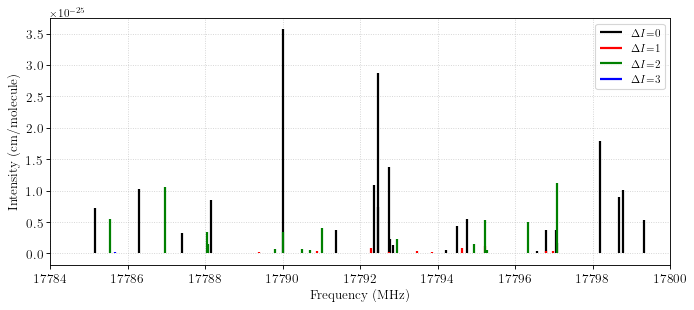

In [14]:
# frequency range (MHz)
nu1 = 17784
nu2 = 17800
freq, abscoef, spin_diff, quanta = stick_spectrum(nu1, nu2)

fig = plt.figure(figsize=(10, 4), dpi=80)

color = ("black", "red", "green", "blue")

for diff in range(4):
    ind = np.where(spin_diff == diff)[0]
    if len(ind) == 0:
        continue

    plt.vlines(
        freq[ind],
        ymin=0,
        ymax=abscoef[ind],
        color=color[diff],
        linewidth=2,
        label=f"$\\Delta I$={diff}",
    )

plt.xlim([nu1, nu2])
plt.grid(True, linestyle=":", alpha=0.6)
plt.xlabel("Frequency (MHz)", fontsize=12)
plt.ylabel("Intensity (cm/molecule)", fontsize=12)
plt.tick_params(axis="both", labelsize=12)
plt.legend()
plt.show()

For comparision, here is an extract of Fig. 3.b from [Mizoguchi]

<img src="../../etc/data/s2cl2/Mizoguchi_JMolSpec250_2008_FIg3.b.png" alt="Extract from Fig. 3 in Mizoguchi, et al. J. Mol. Spectrosc. 250 (2008) 86" width="800"/>

Plot full spectrum.

max acoef: 5.3685597618992805e-24


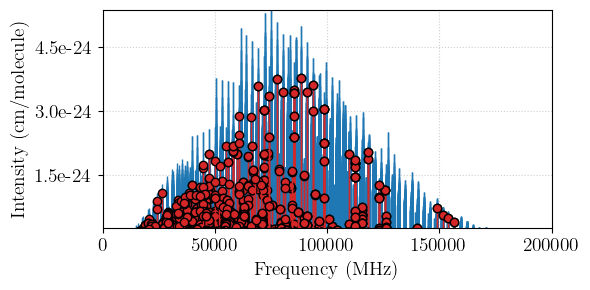

In [16]:
# frequency range (MHz)
nu1 = 0
nu2 = 200000
freq, abscoef, spin_diff, quanta = stick_spectrum(nu1, nu2)

amax = np.max(abscoef)
print("max acoef:", amax)

fig = plt.figure(figsize=(6, 3), dpi=100)


color = ("tab:blue", "tab:red", "tab:blue", "tab:red")
linewidth = (1, 1, 1, 1)
marker = ("", "o", "", "o")

for diff in (0, 2, 1, 3):
    ind = np.where((spin_diff == diff) & (abscoef >= amax * 1e-4))[0]

    if len(ind) == 0:
        continue

    plt.vlines(
        freq[ind],
        ymin=0,
        ymax=abscoef[ind],
        color=color[diff],
        linewidth=linewidth[diff],
        label=f"$\\Delta I$={diff}, {diff+2}" if diff in (0, 1) else "",
    )

    if marker[diff]:
        plt.plot(
            freq[ind],
            abscoef[ind],
            linestyle="None",
            color=color[diff],
            mec="black",
            marker=marker[diff],
            markersize=6,
        )

plt.xlim([nu1, nu2])
plt.ylim([amax * 5e-2, amax])
plt.grid(True, linestyle=":", alpha=0.6)
plt.tick_params(axis="both", labelsize=14)

plt.xlabel("Frequency (cm$^{-1}$)", fontsize=14)
if hyper_states.enr_units == "mhz":
    plt.xlabel("Frequency (MHz)", fontsize=14)
plt.ylabel("Intensity (cm/molecule)", fontsize=14)
# plt.legend(fontsize=14, loc="upper right")

formatter = FuncFormatter(lambda x, _: f"{x:.1e}")
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.tight_layout()

plt.savefig(f"s2cl2_35_37_op_spectrum.pdf", format="pdf", bbox_inches="tight")